# CatBoost Model - Housing Price Prediction

Model du doan gia nha dat su dung CatBoost voi:
- Cross-validation tren tap train
- Optuna hyperparameter tuning
- Danh gia dua tren nhieu metrics

In [26]:
# Import thu vien can thiet
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

# Cau hinh duong dan
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "models" / "catboost"

# Tao thu muc luu model neu chua ton tai
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Model directory: {MODEL_DIR}")

Base directory: D:\DUT_AI\Project\PredictHousing
Data directory: D:\DUT_AI\Project\PredictHousing\data
Model directory: D:\DUT_AI\Project\PredictHousing\models\catboost


## 1. Load va Xu ly Du lieu

In [27]:
# Load du lieu train va test
train_df = pd.read_csv(DATA_DIR / "train_data.csv")
test_df = pd.read_csv(DATA_DIR / "test_data.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nCac cot trong du lieu:")
print(train_df.columns.tolist())

Train shape: (4773, 19)
Test shape: (1194, 19)

Cac cot trong du lieu:
['Diện tích (m2)', 'Hướng', 'Chiều ngang (m)', 'Chiều dài (m)', 'Số phòng ngủ', 'Số phòng vệ sinh', 'Số tầng', 'Tình trạng nội thất', 'Tổng_phòng', 'Aspect_ratio', 'Diện_tích_per_phòng', 'Thành phố_encoded', 'Phường/Xã_encoded', 'Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề', 'Giấy tờ pháp lý_encoded', 'Giá']


In [28]:
# Kiem tra kieu du lieu cua cac cot
print("Kieu du lieu cac cot:")
print(train_df.dtypes)
print(f"\nCac cot bool: {train_df.select_dtypes(include=['bool']).columns.tolist()}")
print(f"Cac cot object (category): {train_df.select_dtypes(include=['object']).columns.tolist()}")

Kieu du lieu cac cot:
Diện tích (m2)                     float64
Hướng                               object
Chiều ngang (m)                    float64
Chiều dài (m)                      float64
Số phòng ngủ                       float64
Số phòng vệ sinh                   float64
Số tầng                            float64
Tình trạng nội thất                 object
Tổng_phòng                           int64
Aspect_ratio                       float64
Diện_tích_per_phòng                float64
Thành phố_encoded                  float64
Phường/Xã_encoded                  float64
Loại hình_Nhà biệt thự                bool
Loại hình_Nhà mặt phố, mặt tiền       bool
Loại hình_Nhà ngõ, hẻm                bool
Loại hình_Nhà phố liền kề             bool
Giấy tờ pháp lý_encoded              int64
Giá                                float64
dtype: object

Cac cot bool: ['Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề']
Cac cot object 

In [29]:
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df, label_encoders=None, fit=True):
    """
    Xu ly du lieu:
    - Chuyen cot bool sang int
    - Label encode cac cot categorical thanh so
    - Chuyen 'Khong xac dinh' thanh NaN (CatBoost xu ly bang nan_mode)
    """
    df = df.copy()
    
    # Lay danh sach cot categorical (object type)
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Cac cot categorical: {cat_cols}")
    
    # Khoi tao label_encoders neu chua co (khi fit=True, tuc la train data)
    if label_encoders is None:
        label_encoders = {}
    
    # Xu ly tung cot categorical
    for col in cat_cols:
        # Dem "Khong xac dinh" truoc khi xu ly
        kxd_count = (df[col] == 'Không xác định').sum()
        
        # Chuyen "Khong xac dinh" thanh NaN TRUOC khi encode
        df[col] = df[col].replace('Không xác định', np.nan)
        
        if kxd_count > 0:
            print(f"Cot '{col}': Da chuyen {kxd_count} 'Khong xac dinh' -> NaN")
        
        # Label encode (chi encode cac gia tri KHONG PHAI NaN)
        if fit:
            # Train: fit va transform
            le = LabelEncoder()
            # Fit tren cac gia tri khong NaN
            non_null_mask = df[col].notna()
            le.fit(df.loc[non_null_mask, col].astype(str))
            label_encoders[col] = le
            print(f"Cot '{col}': Label encode {len(le.classes_)} classes: {list(le.classes_)}")
        
        # Transform: chi transform cac gia tri khong NaN
        le = label_encoders[col]
        non_null_mask = df[col].notna()
        
        # Tao cot moi voi dtype float (de chua NaN)
        encoded_col = pd.Series(index=df.index, dtype=float)
        encoded_col[non_null_mask] = le.transform(df.loc[non_null_mask, col].astype(str))
        encoded_col[~non_null_mask] = np.nan
        
        df[col] = encoded_col
        
        nan_count = df[col].isna().sum()
        print(f"Cot '{col}': {nan_count} NaN (se duoc xu ly boi CatBoost nan_mode)")
        
    # Chuyen cac cot bool sang int
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    for col in bool_cols:
        df[col] = df[col].astype(int)
    print(f"Da chuyen {len(bool_cols)} cot bool sang int: {bool_cols}")
    
    return df, label_encoders

# Ap dung xu ly cho train va test
print("=" * 60)
print("XU LY TRAIN DATA:")
print("=" * 60)
train_df, label_encoders = preprocess_data(train_df, fit=True)

print("\n" + "=" * 60)
print("XU LY TEST DATA:")
print("=" * 60)
test_df, _ = preprocess_data(test_df, label_encoders=label_encoders, fit=False)

print(f"\nTrain shape sau xu ly: {train_df.shape}")
print(f"Test shape sau xu ly: {test_df.shape}")

# Kiem tra NaN trong data
print(f"\nSo luong NaN trong train:")
for col in train_df.columns:
    nan_count = train_df[col].isna().sum()
    if nan_count > 0:
        print(f"  {col}: {nan_count} NaN")

# Luu label_encoders de su dung sau
print(f"\nLabel encoders da luu cho {len(label_encoders)} cot: {list(label_encoders.keys())}")

XU LY TRAIN DATA:
Cac cot categorical: ['Hướng', 'Tình trạng nội thất']
Cot 'Hướng': Da chuyen 3570 'Khong xac dinh' -> NaN
Cot 'Hướng': Label encode 8 classes: ['Bắc', 'Nam', 'Tây', 'Tây Bắc', 'Tây Nam', 'Đông', 'Đông Bắc', 'Đông Nam']
Cot 'Hướng': 3570 NaN (se duoc xu ly boi CatBoost nan_mode)
Cot 'Tình trạng nội thất': Da chuyen 2265 'Khong xac dinh' -> NaN
Cot 'Tình trạng nội thất': Label encode 4 classes: ['Bàn giao thô', 'Hoàn thiện cơ bản', 'Nội thất cao cấp', 'Nội thất đầy đủ']
Cot 'Tình trạng nội thất': 2265 NaN (se duoc xu ly boi CatBoost nan_mode)
Da chuyen 4 cot bool sang int: ['Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề']

XU LY TEST DATA:
Cac cot categorical: ['Hướng', 'Tình trạng nội thất']
Cot 'Hướng': Da chuyen 882 'Khong xac dinh' -> NaN
Cot 'Hướng': 882 NaN (se duoc xu ly boi CatBoost nan_mode)
Cot 'Tình trạng nội thất': Da chuyen 591 'Khong xac dinh' -> NaN
Cot 'Tình trạng nội thất': 591 NaN (se d

In [30]:
# Tach features va target
TARGET_COL = 'Giá'

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

# KHONG con categorical features vi da encode thanh so
# CatBoost se xu ly NaN bang nan_mode='Min' (mac dinh)
cat_features = []  # Khong co cat features
cat_feature_indices = []

print(f"Feature count: {X_train.shape[1]}")
print(f"Categorical features: KHONG CO (da encode thanh so)")
print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Kiem tra NaN trong features
print(f"\nNaN trong X_train:")
for col in X_train.columns:
    nan_count = X_train[col].isna().sum()
    if nan_count > 0:
        print(f"  {col}: {nan_count} NaN -> CatBoost xu ly bang nan_mode='Min'")

Feature count: 18
Categorical features: KHONG CO (da encode thanh so)

Train samples: 4773
Test samples: 1194

NaN trong X_train:
  Hướng: 3570 NaN -> CatBoost xu ly bang nan_mode='Min'
  Tình trạng nội thất: 2265 NaN -> CatBoost xu ly bang nan_mode='Min'


## 2. Cau hinh Train

In [31]:
# Cau hinh train - Chon CPU hoac GPU
# Doi DEVICE = "GPU" neu co GPU CUDA

DEVICE = "CPU"  # Options: "CPU" hoac "GPU"

# Cau hinh cross-validation
N_FOLDS = 5
RANDOM_STATE = 42

# Cau hinh Optuna
N_TRIALS = 200  # So luong trials cho hyperparameter tuning
OPTUNA_TIMEOUT = None  # Gioi han thoi gian (seconds), None = khong gioi han

# Vi GPU khong the chay nhieu trials song song (conflict device)
# Chi dung N_JOBS = -1 khi DEVICE = "CPU"
N_JOBS = 1 if DEVICE == "GPU" else -1

print(f"Device: {DEVICE}")
print(f"Cross-validation folds: {N_FOLDS}")
print(f"N_JOBS: {N_JOBS} {'(GPU bat buoc chay tuan tu)' if DEVICE == 'GPU' else '(CPU chay song song)'}")

Device: CPU
Cross-validation folds: 5
N_JOBS: -1 (CPU chay song song)


## 3. Optuna Hyperparameter Tuning

In [32]:
def objective(trial):
    """
    Ham objective cho Optuna tim kiem hyperparameters toi uu
    Su dung cross-validation voi R2 score (maximize)
    
    NOTE: Khong dung cat_features vi da label encode thanh so
    CatBoost xu ly NaN bang nan_mode='Min' (mac dinh)
    """
    # Hyperparameters search space - REGULARIZATION FOCUS
    params = {
        'iterations': trial.suggest_int('iterations', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 6),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 100.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1.0, 20.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        
        # Co dinh params
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE,
        'verbose': 0,
        'task_type': DEVICE,
        'nan_mode': 'Min',  # Xu ly NaN: dat gia tri NaN = Min cua feature
        # KHONG dung cat_features vi da encode thanh so
    }
    
    # Cross-validation
    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    rmse_scores = []
    r2_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Tao Pool cho CatBoost (KHONG co cat_features)
        train_pool = Pool(X_fold_train, y_fold_train)
        val_pool = Pool(X_fold_val, y_fold_val)
        
        # Train model
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)
        
        # Predict va tinh metrics
        y_pred = model.predict(X_fold_val)
        rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
        r2 = r2_score(y_fold_val, y_pred)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    # Tra ve R2 trung binh (maximize)
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    
    trial.set_user_attr('mean_r2', mean_r2)
    trial.set_user_attr('mean_rmse', mean_rmse)
    
    print(f"Trial {trial.number:3d}: R2 = {mean_r2:.6f}, RMSE = {mean_rmse:.6f}")
    
    return mean_r2

print("Objective function da san sang (R2 metric - maximize)")
print("NOTE: Da label encode categorical -> CatBoost xu ly NaN bang nan_mode='Min'")

Objective function da san sang (R2 metric - maximize)
NOTE: Da label encode categorical -> CatBoost xu ly NaN bang nan_mode='Min'


In [33]:
# Callback hien thi ca R2 va RMSE cho tung trial
def trial_callback(study, trial):
    """Callback hien thi metrics sau moi trial"""
    r2 = trial.value
    rmse = trial.user_attrs.get('mean_rmse', 'N/A')
    if isinstance(rmse, float):
        print(f"Trial {trial.number}: R2 = {r2:.6f}, RMSE = {rmse:.6f}")
    
# Chay Optuna optimization
# Toi uu hoa R2 score (maximize)
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Giam log mac dinh

study = optuna.create_study(
    direction='maximize',  # Maximize R2 score
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='catboost_housing_price'
)

print(f"Bat dau Optuna hyperparameter tuning...")
print(f"Trials: {N_TRIALS}, Folds: {N_FOLDS}, Device: {DEVICE}")
print(f"Metric: R2 Score (maximize)")
print(f"Mode: {'Tuan tu (n_jobs=1)' if N_JOBS == 1 else f'Song song (n_jobs={N_JOBS})'}")
print("-" * 60)

study.optimize(
    objective, 
    n_trials=N_TRIALS, 
    timeout=OPTUNA_TIMEOUT,
    n_jobs=N_JOBS,
    show_progress_bar=True,
    callbacks=[trial_callback] if N_JOBS == 1 else None  # Callback chi hoat dong khi n_jobs=1
)

print("-" * 60)
# Hien thi best trial voi R2 Score
best_trial = study.best_trial
best_r2 = best_trial.value

print(f"\nBest Trial: #{best_trial.number}")
print(f"  Best R2 Score: {best_r2:.6f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Bat dau Optuna hyperparameter tuning...
Trials: 200, Folds: 5, Device: CPU
Metric: R2 Score (maximize)
Mode: Song song (n_jobs=-1)
------------------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Trial  13: R2 = 0.463979, RMSE = 2.748960
Trial   9: R2 = 0.588736, RMSE = 2.407445
Trial  10: R2 = 0.601068, RMSE = 2.370974
Trial   7: R2 = 0.680421, RMSE = 2.122014
Trial   6: R2 = 0.598824, RMSE = 2.377492
Trial   5: R2 = 0.631458, RMSE = 2.278883
Trial   3: R2 = 0.682557, RMSE = 2.114563
Trial  12: R2 = 0.592748, RMSE = 2.395611
Trial  16: R2 = 0.688831, RMSE = 2.093565
Trial  21: R2 = 0.508801, RMSE = 2.631424
Trial   1: R2 = 0.535182, RMSE = 2.559592
Trial  17: R2 = 0.619716, RMSE = 2.315007
Trial  15: R2 = 0.686598, RMSE = 2.101061
Trial  24: R2 = 0.453762, RMSE = 2.774824
Trial   8: R2 = 0.672276, RMSE = 2.148821
Trial   0: R2 = 0.679668, RMSE = 2.124351
Trial   4: R2 = 0.688606, RMSE = 2.094562
Trial  14: R2 = 0.691711, RMSE = 2.083915
Trial  27: R2 = 0.688650, RMSE = 2.094193
Trial  23: R2 = 0.624733, RMSE = 2.299496
Trial  20: R2 = 0.658030, RMSE = 2.195184
Trial  11: R2 = 0.661166, RMSE = 2.184940
Trial  29: R2 = 0.689171, RMSE = 2.092615
Trial  30: R2 = 0.688498, RMSE = 2

## 4. Train Final Model voi Best Hyperparameters

In [34]:
# Tao final model voi best hyperparameters
best_params = study.best_params.copy()
best_params.update({
    'loss_function': 'RMSE',
    'eval_metric': 'R2',
    'random_seed': RANDOM_STATE,
    'task_type': DEVICE,
    'nan_mode': 'Min',  # Xu ly NaN
    'verbose': 100,
    # KHONG dung cat_features vi da encode thanh so
})

print("Best hyperparameters cho final model:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Best hyperparameters cho final model:
  iterations: 536
  learning_rate: 0.063870888754882
  depth: 6
  l2_leaf_reg: 3.8642047356679776
  bagging_temperature: 0.3407109098114514
  random_strength: 1.2445438028841713
  border_count: 82
  min_data_in_leaf: 25
  loss_function: RMSE
  eval_metric: R2
  random_seed: 42
  task_type: CPU
  nan_mode: Min
  verbose: 100


In [35]:
# Cross-validation voi final model (hien thi chi tiet tung fold)
print("=" * 70)
print("CROSS-VALIDATION VOI BEST HYPERPARAMETERS")
print("=" * 70)

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_results = {
    'r2': [], 'rmse': [], 'mae': [], 'mape': []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    print(f"\n{'='*70}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*70}")
    
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Tao Pool (KHONG co cat_features)
    train_pool = Pool(X_fold_train, y_fold_train)
    val_pool = Pool(X_fold_val, y_fold_val)
    
    # Train model
    fold_model = CatBoostRegressor(**best_params)
    fold_model.fit(
        train_pool, 
        eval_set=val_pool, 
        early_stopping_rounds=50,
        use_best_model=True
    )
    
    # Predict va tinh metrics
    y_pred = fold_model.predict(X_fold_val)
    
    fold_r2 = r2_score(y_fold_val, y_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    fold_mae = mean_absolute_error(y_fold_val, y_pred)
    fold_mape = mean_absolute_percentage_error(y_fold_val, y_pred) * 100
    
    cv_results['r2'].append(fold_r2)
    cv_results['rmse'].append(fold_rmse)
    cv_results['mae'].append(fold_mae)
    cv_results['mape'].append(fold_mape)
    
    print(f"\nFold {fold + 1} Results:")
    print(f"  R2 Score: {fold_r2:.6f}")
    print(f"  RMSE: {fold_rmse:.6f}")
    print(f"  MAE: {fold_mae:.6f}")
    print(f"  MAPE: {fold_mape:.2f}%")

# Tong ket cross-validation
print("\n" + "=" * 70)
print("TONG KET CROSS-VALIDATION")
print("=" * 70)
print(f"R2 Score:  {np.mean(cv_results['r2']):.6f} (+/- {np.std(cv_results['r2']):.6f})")
print(f"RMSE:      {np.mean(cv_results['rmse']):.6f} (+/- {np.std(cv_results['rmse']):.6f})")
print(f"MAE:       {np.mean(cv_results['mae']):.6f} (+/- {np.std(cv_results['mae']):.6f})")
print(f"MAPE:      {np.mean(cv_results['mape']):.2f}% (+/- {np.std(cv_results['mape']):.2f}%)")

CROSS-VALIDATION VOI BEST HYPERPARAMETERS

FOLD 1/5
0:	learn: 0.0591211	test: 0.0572685	best: 0.0572685 (0)	total: 1.55ms	remaining: 832ms
100:	learn: 0.7174431	test: 0.6714999	best: 0.6714999 (100)	total: 141ms	remaining: 606ms
200:	learn: 0.7679037	test: 0.6912330	best: 0.6912330 (200)	total: 281ms	remaining: 469ms
300:	learn: 0.8011064	test: 0.6979342	best: 0.6979342 (300)	total: 428ms	remaining: 334ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.699764655
bestIteration = 336

Shrink model to first 337 iterations.

Fold 1 Results:
  R2 Score: 0.699765
  RMSE: 2.034609
  MAE: 1.396882
  MAPE: 31.73%

FOLD 2/5
0:	learn: 0.0598232	test: 0.0555205	best: 0.0555205 (0)	total: 1.59ms	remaining: 854ms
100:	learn: 0.7219581	test: 0.6492125	best: 0.6492125 (100)	total: 147ms	remaining: 632ms
200:	learn: 0.7735568	test: 0.6636577	best: 0.6638112 (199)	total: 284ms	remaining: 474ms
300:	learn: 0.8099336	test: 0.6679774	best: 0.6684623 (282)	total: 448ms	remaining: 349ms
S

In [36]:
# Train final model tren toan bo tap train
print("\n" + "=" * 70)
print("TRAIN FINAL MODEL TREN TOAN BO TAP TRAIN")
print("=" * 70)

# Tao Pool cho full training data (KHONG co cat_features)
full_train_pool = Pool(X_train, y_train)

# Train final model
final_model = CatBoostRegressor(**best_params)
final_model.fit(full_train_pool)

print(f"\nFinal model da duoc train voi {len(X_train)} samples")
print(f"Best iteration: {final_model.best_iteration_}")
print(f"NaN mode: Min (gia tri NaN duoc coi nhu gia tri nho nhat)")


TRAIN FINAL MODEL TREN TOAN BO TAP TRAIN
0:	learn: 0.0588980	total: 1.8ms	remaining: 961ms
100:	learn: 0.7149261	total: 164ms	remaining: 705ms
200:	learn: 0.7625742	total: 350ms	remaining: 583ms
300:	learn: 0.7956595	total: 501ms	remaining: 391ms
400:	learn: 0.8192080	total: 658ms	remaining: 221ms
500:	learn: 0.8371919	total: 815ms	remaining: 56.9ms
535:	learn: 0.8424948	total: 876ms	remaining: 0us

Final model da duoc train voi 4773 samples
Best iteration: None
NaN mode: Min (gia tri NaN duoc coi nhu gia tri nho nhat)


## 5. Danh gia tren Test Set

In [37]:
# Danh gia tren Train va Test set (kiem tra overfitting)
print("=" * 70)
print("DANH GIA MODEL - SO SANH TRAIN VS TEST")
print("=" * 70)

# Predict tren TRAIN set (du lieu model DA HOC)
y_train_pred = final_model.predict(X_train)
train_metrics = {
    'r2_score': r2_score(y_train, y_train_pred),
    'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'mae': mean_absolute_error(y_train, y_train_pred),
    'mape': mean_absolute_percentage_error(y_train, y_train_pred) * 100,
}

# Predict tren TEST set (du lieu model CHUA THAY)
y_test_pred = final_model.predict(X_test)
test_metrics = {
    'r2_score': r2_score(y_test, y_test_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'mae': mean_absolute_error(y_test, y_test_pred),
    'mape': mean_absolute_percentage_error(y_test, y_test_pred) * 100,
    'mse': mean_squared_error(y_test, y_test_pred),
}

# Them metric phu cho test
test_metrics['explained_variance'] = 1 - (np.var(y_test - y_test_pred) / np.var(y_test))
test_metrics['max_error'] = np.max(np.abs(y_test - y_test_pred))
test_metrics['median_absolute_error'] = np.median(np.abs(y_test - y_test_pred))

# So sanh Train vs Test
print(f"\n{'Metric':<15} {'Train':>15} {'Test':>15} {'Gap':>15}")
print("-" * 60)
print(f"{'R2 Score':<15} {train_metrics['r2_score']:>15.6f} {test_metrics['r2_score']:>15.6f} {train_metrics['r2_score'] - test_metrics['r2_score']:>+15.6f}")
print(f"{'RMSE':<15} {train_metrics['rmse']:>15.6f} {test_metrics['rmse']:>15.6f} {train_metrics['rmse'] - test_metrics['rmse']:>+15.6f}")
print(f"{'MAE':<15} {train_metrics['mae']:>15.6f} {test_metrics['mae']:>15.6f} {train_metrics['mae'] - test_metrics['mae']:>+15.6f}")
print(f"{'MAPE':<15} {train_metrics['mape']:>14.2f}% {test_metrics['mape']:>14.2f}% {train_metrics['mape'] - test_metrics['mape']:>+14.2f}%")

# Phan tich overfitting
r2_gap = train_metrics['r2_score'] - test_metrics['r2_score']
print(f"\n" + "=" * 60)
print("PHAN TICH OVERFITTING:")
if r2_gap > 0.1:
    print(f"    R2 Gap = {r2_gap:.4f} > 0.1 → Co dau hieu OVERFITTING")
elif r2_gap > 0.05:
    print(f"   R2 Gap = {r2_gap:.4f} → Overfitting nhe, chap nhan duoc")
else:
    print(f"   R2 Gap = {r2_gap:.4f} → Model GENERALIZE TOT!")

print(f"\nTest Set Metrics (chi tiet):")
print(f"  MSE:                   {test_metrics['mse']:.6f}")
print(f"  Explained Variance:    {test_metrics['explained_variance']:.6f}")
print(f"  Max Error:             {test_metrics['max_error']:.6f}")
print(f"  Median Absolute Error: {test_metrics['median_absolute_error']:.6f}")

DANH GIA MODEL - SO SANH TRAIN VS TEST

Metric                    Train            Test             Gap
------------------------------------------------------------
R2 Score               0.842495        0.686600       +0.155895
RMSE                   1.491498        2.069110       -0.577612
MAE                    1.063029        1.360001       -0.296973
MAPE                     22.55%          29.53%          -6.98%

PHAN TICH OVERFITTING:
    R2 Gap = 0.1559 > 0.1 → Co dau hieu OVERFITTING

Test Set Metrics (chi tiet):
  MSE:                   4.281216
  Explained Variance:    0.686624
  Max Error:             13.367471
  Median Absolute Error: 0.907365


## 6. Feature Importance

Feature Importance (Top 15):
----------------------------------------
Phường/Xã_encoded                       : 21.9751
Thành phố_encoded                       : 13.3067
Số phòng vệ sinh                        : 10.2034
Diện tích (m2)                          : 9.2573
Chiều dài (m)                           : 7.0236
Tổng_phòng                              : 6.8778
Số tầng                                 : 5.2330
Chiều ngang (m)                         : 4.8022
Loại hình_Nhà mặt phố, mặt tiền         : 4.7947
Diện_tích_per_phòng                     : 3.4792
Aspect_ratio                            : 3.1685
Loại hình_Nhà ngõ, hẻm                  : 2.5850
Số phòng ngủ                            : 2.3761
Hướng                                   : 1.6084
Giấy tờ pháp lý_encoded                 : 1.5938


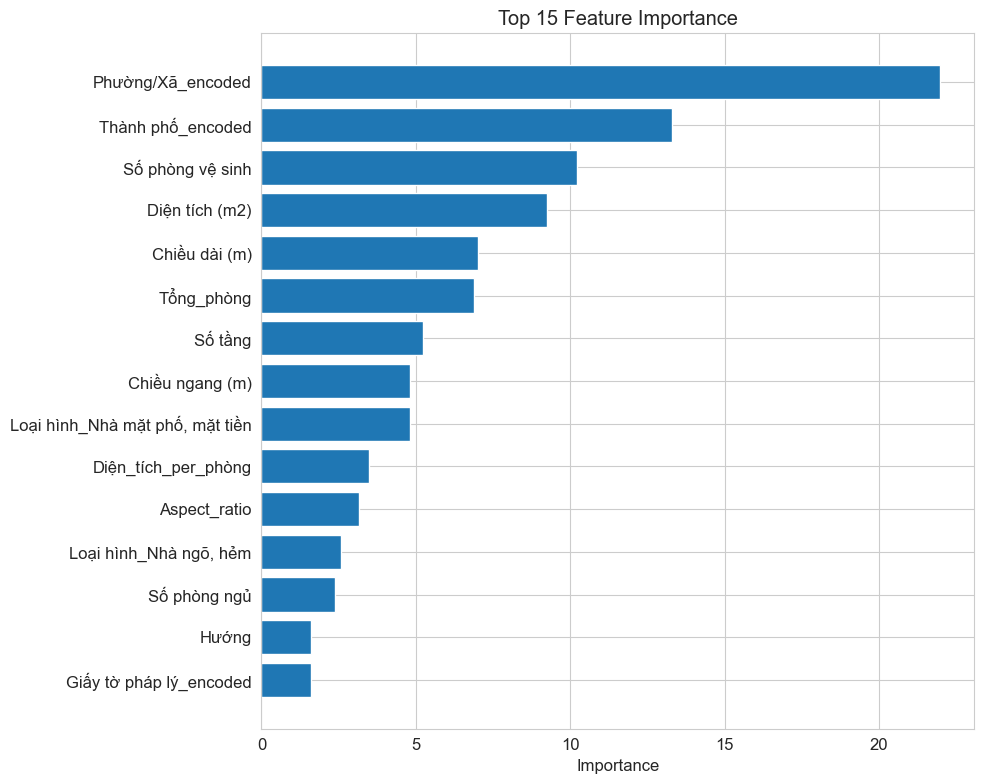

In [38]:
# Lay feature importance
feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns.tolist()

# Sap xep theo importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance (Top 15):")
print("-" * 40)
for idx, row in importance_df.head(15).iterrows():
    print(f"{row['feature']:40s}: {row['importance']:.4f}")

# Hien thi bieu do
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'].head(15)[::-1], importance_df['importance'].head(15)[::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

## 7. Luu Model va Ket qua

In [39]:
# Luu model CatBoost
model_path = MODEL_DIR / "catboost_model.cbm"
final_model.save_model(str(model_path))
print(f"Model da duoc luu tai: {model_path}")

# Luu feature names
feature_names_path = MODEL_DIR / "feature_names.json"
feature_names_data = {
    'feature_names': feature_names,
    'categorical_features': cat_features,
    'categorical_feature_indices': cat_feature_indices,
    'target_column': TARGET_COL
}
with open(feature_names_path, 'w', encoding='utf-8') as f:
    json.dump(feature_names_data, f, ensure_ascii=False, indent=2)
print(f"Feature names da duoc luu tai: {feature_names_path}")

# Luu metrics
metrics_path = MODEL_DIR / "metrics.json"
all_metrics = {
    'test_metrics': test_metrics,
    'cv_metrics': {
        'r2_mean': float(np.mean(cv_results['r2'])),
        'r2_std': float(np.std(cv_results['r2'])),
        'rmse_mean': float(np.mean(cv_results['rmse'])),
        'rmse_std': float(np.std(cv_results['rmse'])),
        'mae_mean': float(np.mean(cv_results['mae'])),
        'mae_std': float(np.std(cv_results['mae'])),
        'mape_mean': float(np.mean(cv_results['mape'])),
        'mape_std': float(np.std(cv_results['mape'])),
    },
    'best_optuna_r2': float(study.best_value),
    'n_folds': N_FOLDS,
    'n_trials': N_TRIALS,
    'device': DEVICE
}
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(all_metrics, f, ensure_ascii=False, indent=2)
print(f"Metrics da duoc luu tai: {metrics_path}")

# Luu best hyperparameters
hyperparams_path = MODEL_DIR / "best_hyperparameters.json"
best_params_save = {k: v for k, v in best_params.items() if k != 'cat_features'}
best_params_save['cat_features'] = cat_features  # Luu ten thay vi index
with open(hyperparams_path, 'w', encoding='utf-8') as f:
    json.dump(best_params_save, f, ensure_ascii=False, indent=2)
print(f"Best hyperparameters da duoc luu tai: {hyperparams_path}")

# Luu feature importance
importance_path = MODEL_DIR / "feature_importance.json"
importance_dict = importance_df.set_index('feature')['importance'].to_dict()
with open(importance_path, 'w', encoding='utf-8') as f:
    json.dump(importance_dict, f, ensure_ascii=False, indent=2)
print(f"Feature importance da duoc luu tai: {importance_path}")

Model da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\catboost_model.cbm
Feature names da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\feature_names.json
Metrics da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\metrics.json
Best hyperparameters da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\best_hyperparameters.json
Feature importance da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\feature_importance.json


In [40]:
# Tong ket cuoi cung
print("\n" + "=" * 70)
print("TONG KET")
print("=" * 70)
print(f"\nModel: CatBoost Regressor")
print(f"Device: {DEVICE}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_names)}")
print(f"Categorical features: {len(cat_features)}")

print(f"\nOptuna Tuning:")
print(f"  Trials: {N_TRIALS}")
print(f"  Best CV R2: {study.best_value:.6f}")

print(f"\nCross-validation ({N_FOLDS} folds):")
print(f"  R2: {np.mean(cv_results['r2']):.6f} (+/- {np.std(cv_results['r2']):.6f})")

print(f"\nTest Set Performance:")
print(f"  R2 Score: {test_metrics['r2_score']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE: {test_metrics['mae']:.6f}")
print(f"  MAPE: {test_metrics['mape']:.2f}%")

print(f"\nFiles da luu tai {MODEL_DIR}:")
for f in MODEL_DIR.glob("*"):
    print(f"  - {f.name}")


TONG KET

Model: CatBoost Regressor
Device: CPU
Training samples: 4773
Test samples: 1194
Features: 18
Categorical features: 0

Optuna Tuning:
  Trials: 200
  Best CV R2: 0.694903

Cross-validation (5 folds):
  R2: 0.694903 (+/- 0.018677)

Test Set Performance:
  R2 Score: 0.686600
  RMSE: 2.069110
  MAE: 1.360001
  MAPE: 29.53%

Files da luu tai D:\DUT_AI\Project\PredictHousing\models\catboost:
  - best_hyperparameters.json
  - catboost_learning_curve.png
  - catboost_model.cbm
  - feature_importance.json
  - feature_names.json
  - metrics.json


## 8. Load va Su dung Model (Optional)

In [41]:
# Load model da luu de su dung
def load_catboost_model(model_dir):
    """Load model va cac thong tin lien quan"""
    model_dir = Path(model_dir)
    
    # Load model
    model = CatBoostRegressor()
    model.load_model(str(model_dir / "catboost_model.cbm"))
    
    # Load feature names
    with open(model_dir / "feature_names.json", 'r', encoding='utf-8') as f:
        feature_info = json.load(f)
    
    # Load metrics
    with open(model_dir / "metrics.json", 'r', encoding='utf-8') as f:
        metrics = json.load(f)
    
    return model, feature_info, metrics

# Test load model
loaded_model, loaded_feature_info, loaded_metrics = load_catboost_model(MODEL_DIR)
print("Model loaded successfully!")
print(f"Test R2 from loaded metrics: {loaded_metrics['test_metrics']['r2_score']:.6f}")

# Test predict voi model loaded
test_pred = loaded_model.predict(X_test[:5])
print(f"\nPredictions (5 mau dau):")
for i, (pred, actual) in enumerate(zip(test_pred, y_test[:5].values)):
    print(f"  Sample {i+1}: Predicted={pred:.2f}, Actual={actual:.2f}")

Model loaded successfully!
Test R2 from loaded metrics: 0.686600

Predictions (5 mau dau):
  Sample 1: Predicted=8.36, Actual=10.25
  Sample 2: Predicted=4.20, Actual=4.00
  Sample 3: Predicted=4.79, Actual=4.68
  Sample 4: Predicted=1.11, Actual=1.55
  Sample 5: Predicted=4.92, Actual=4.70


## 9. In ảnh hiển thị trong báo cáo - ra catboost_learning_curve.png

Training model voi eval_set de ve learning curve...
Model trained: 480 iterations
Available metrics in learn: ['R2', 'RMSE']
Available metrics in validation: ['R2', 'RMSE']

Da luu anh: D:\DUT_AI\Project\PredictHousing\models\catboost\catboost_learning_curve.png


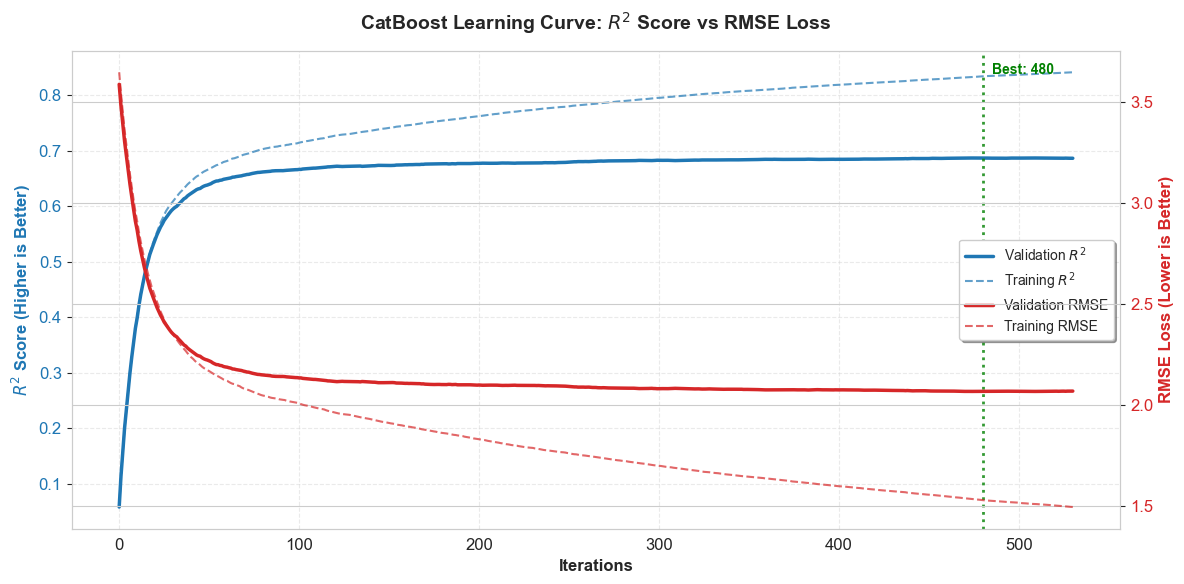


Final metrics at best iteration (480):
  Train R2:    0.834249
  Val R2:      0.687169
  Train RMSE:  1.530041
  Val RMSE:    2.067231

File anh da luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\catboost_learning_curve.png


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiet lap style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# ============================================================
# TRAIN LAI MODEL VOI EVAL_SET DE CO LICH SU LEARNING CURVE
# ============================================================
print("Training model voi eval_set de ve learning curve...")

# Tao Pool (KHONG co cat_features)
train_pool_viz = Pool(X_train, y_train)
test_pool_viz = Pool(X_test, y_test)

# Tao params cho visualization model
viz_params = best_params.copy()
viz_params['loss_function'] = 'RMSE'
viz_params['eval_metric'] = 'R2'
viz_params['custom_metric'] = ['RMSE']
viz_params['verbose'] = 0

# Train model voi eval_set
viz_model = CatBoostRegressor(**viz_params)
viz_model.fit(
    train_pool_viz, 
    eval_set=test_pool_viz,
    early_stopping_rounds=50,
    use_best_model=True
)

print(f"Model trained: {viz_model.best_iteration_} iterations")

# ============================================================
# VE BIEU DO LEARNING CURVE
# ============================================================
def plot_dual_axis_learning_curve(model, save_dir=None):
    """
    Ve bieu do 2 truc: R2 (truc trai) va RMSE (truc phai)
    """
    results = model.get_evals_result()
    
    print(f"Available metrics in learn: {list(results['learn'].keys())}")
    print(f"Available metrics in validation: {list(results['validation'].keys())}")
    
    epochs = len(results['validation']['R2'])
    x_axis = range(0, epochs)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # --- TRUC TRAI: R2 SCORE ---
    color_r2 = '#1f77b4'
    ax1.set_xlabel('Iterations', fontsize=12, fontweight='bold')
    ax1.set_ylabel('$R^2$ Score (Higher is Better)', color=color_r2, fontsize=12, fontweight='bold')
    
    l1 = ax1.plot(x_axis, results['validation']['R2'], label='Validation $R^2$', 
                 color=color_r2, linewidth=2.5)
    l2 = ax1.plot(x_axis, results['learn']['R2'], label='Training $R^2$', 
                 color=color_r2, linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax1.tick_params(axis='y', labelcolor=color_r2)
    ax1.grid(True, linestyle='--', alpha=0.4)

    # --- TRUC PHAI: RMSE LOSS ---
    ax2 = ax1.twinx()
    color_rmse = '#d62728'
    ax2.set_ylabel('RMSE Loss (Lower is Better)', color=color_rmse, fontsize=12, fontweight='bold')
    
    l3 = ax2.plot(x_axis, results['validation']['RMSE'], label='Validation RMSE', 
                 color=color_rmse, linewidth=2.5)
    l4 = ax2.plot(x_axis, results['learn']['RMSE'], label='Training RMSE', 
                 color=color_rmse, linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax2.tick_params(axis='y', labelcolor=color_rmse)

    # --- LEGEND ---
    lns = l1 + l2 + l3 + l4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='center right', frameon=True, fancybox=True, shadow=True, fontsize=10)

    # Best iteration line
    best_iter = model.best_iteration_
    if best_iter is not None and best_iter > 0:
        ax1.axvline(x=best_iter, color='green', linestyle=':', linewidth=2, alpha=0.8)
        y_pos = ax1.get_ylim()[0] + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.95
        ax1.text(best_iter + 5, y_pos, f'Best: {best_iter}', 
                 color='green', fontsize=10, fontweight='bold')

    plt.title('CatBoost Learning Curve: $R^2$ Score vs RMSE Loss', fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()

    if save_dir:
        filename = save_dir / 'catboost_learning_curve.png'
    else:
        filename = 'catboost_learning_curve.png'
    
    plt.savefig(str(filename), dpi=300, bbox_inches='tight')
    print(f"\nDa luu anh: {filename}")
    plt.show()
    
    best_idx = min(best_iter, epochs) - 1 if best_iter else epochs - 1
    print(f"\nFinal metrics at best iteration ({best_iter}):")
    print(f"  Train R2:    {results['learn']['R2'][best_idx]:.6f}")
    print(f"  Val R2:      {results['validation']['R2'][best_idx]:.6f}")
    print(f"  Train RMSE:  {results['learn']['RMSE'][best_idx]:.6f}")
    print(f"  Val RMSE:    {results['validation']['RMSE'][best_idx]:.6f}")
    
    return filename

output_path = plot_dual_axis_learning_curve(viz_model, save_dir=MODEL_DIR)
print(f"\nFile anh da luu tai: {output_path}")